# 앙상블 모델
- 배깅: 데이터를 랜덤하게 (다양하게) 사용하는 것 (예 랜덤 포레스트)
- 부스팅: 모델을 순차적으로 개선하는 것 (예, xgboost, lightgbm)
- 스태킹: 여러 다양한 모델의 결과를 취합하는 것

# 배깅
- "같은" 모델을 사용하고 데이터를 무작위로 달리 사용한다
- 배깅: 중복허용 (bootstrap aggregation)
- 병렬로 처리할 수 있다
- 랜덤 포레스트는 배깅을 적용한 결정트리 앙상블 기법

## RandomForest

In [9]:
from sklearn import datasets
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

### 손글씨 데이터 로드

In [10]:
mnist = datasets.load_digits()
features, labels = mnist.data, mnist.target

### 교차 검증
교차 검증을 10번 수행하여, 10번의 교차 검증 평균 정확도를 저장합니다.

In [11]:
def cross_validation(classifier,features, labels):
    cv_scores = []

    for i in range(10):
        scores = cross_val_score(classifier, features, labels, cv=10, scoring='accuracy')
        cv_scores.append(scores.mean())
    
    return cv_scores

In [12]:
dt_cv_scores = cross_validation(tree.DecisionTreeClassifier(), features, labels)

In [13]:
rf_cv_scores = cross_validation(RandomForestClassifier(), features, labels)

### 성능 시각화
라인 차트를 통해 랜덤포레스트가 의사결정트리보다 매번 정확도가 높은 것을 확인할 수 있습니다.

In [14]:
cv_list = {  'random_forest':rf_cv_scores,
             'decision_tree':dt_cv_scores,
          }
df = pd.DataFrame.from_dict(cv_list)

<Axes: >

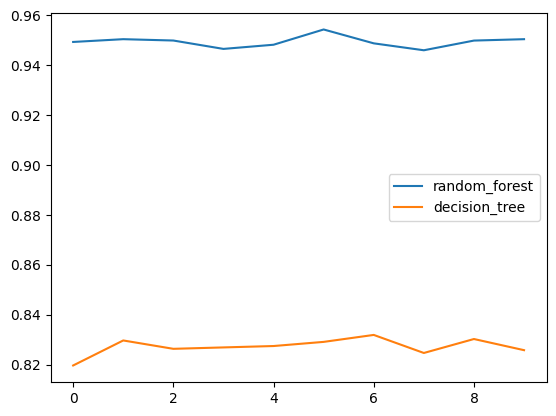

In [15]:
df.plot()

### 정확도

In [16]:
# 결정트리
print(np.mean(dt_cv_scores))

# RandomForest
print(np.mean(rf_cv_scores))

0.8271964618249535
0.9494124767225325


# 부스팅

## 그라디언트 부스팅
- 그라디언트 부스팅에서는 앞단계 모델의 "예측 오차"를 예측하는 모델을 만든다
- 즉, y가 아니라 e를 예측하는 모델을 계속 만드는 작업을 한다.
- 각 단계의 "간단한" 모델로 결정트리를 사용한다

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [18]:
# 샘플 데이터 생성
N = 100
np.random.seed(42)
X = np.random.rand(N, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(N) 
# y = 3*x^2 + noise

In [19]:
X[:3]

array([[-0.12545988],
       [ 0.45071431],
       [ 0.23199394]])

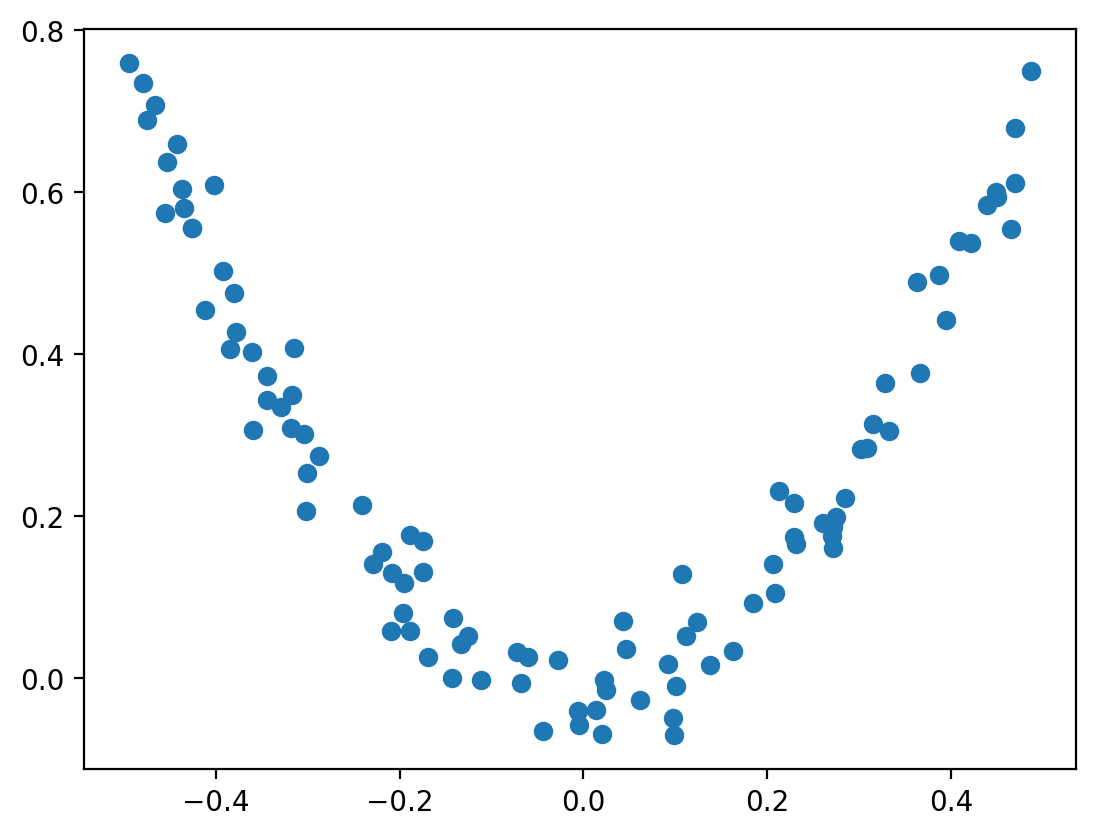

In [20]:
plt.scatter(X,y)

In [21]:
#  X -> y 기본 예측기 : reg1
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [22]:
# X -> e 예측기 (e는 오차) : reg2는 reg1의 예측 오차를 추정하도록 학습
e = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, e)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [23]:
# X -> e2 예측기 (e2는 오차의 오차) : reg3는 reg2의 예측 오차를 추정하도록 학습

e2 = e - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, e2)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [24]:
X_sample = np.array([[-0.3], [0], [0.2]])

# 3개의 모델의 합을 구한다
y_pred = sum(tree.predict(X_sample) for tree in (tree_reg1, tree_reg2, tree_reg3))
y_pred # y = 3*x^2 + noise

array([0.29044761, 0.04021166, 0.17052257])

In [25]:
# regressors가 3개라면, 각 regressor의 예측값의 합을 최종 예측값으로 사용
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

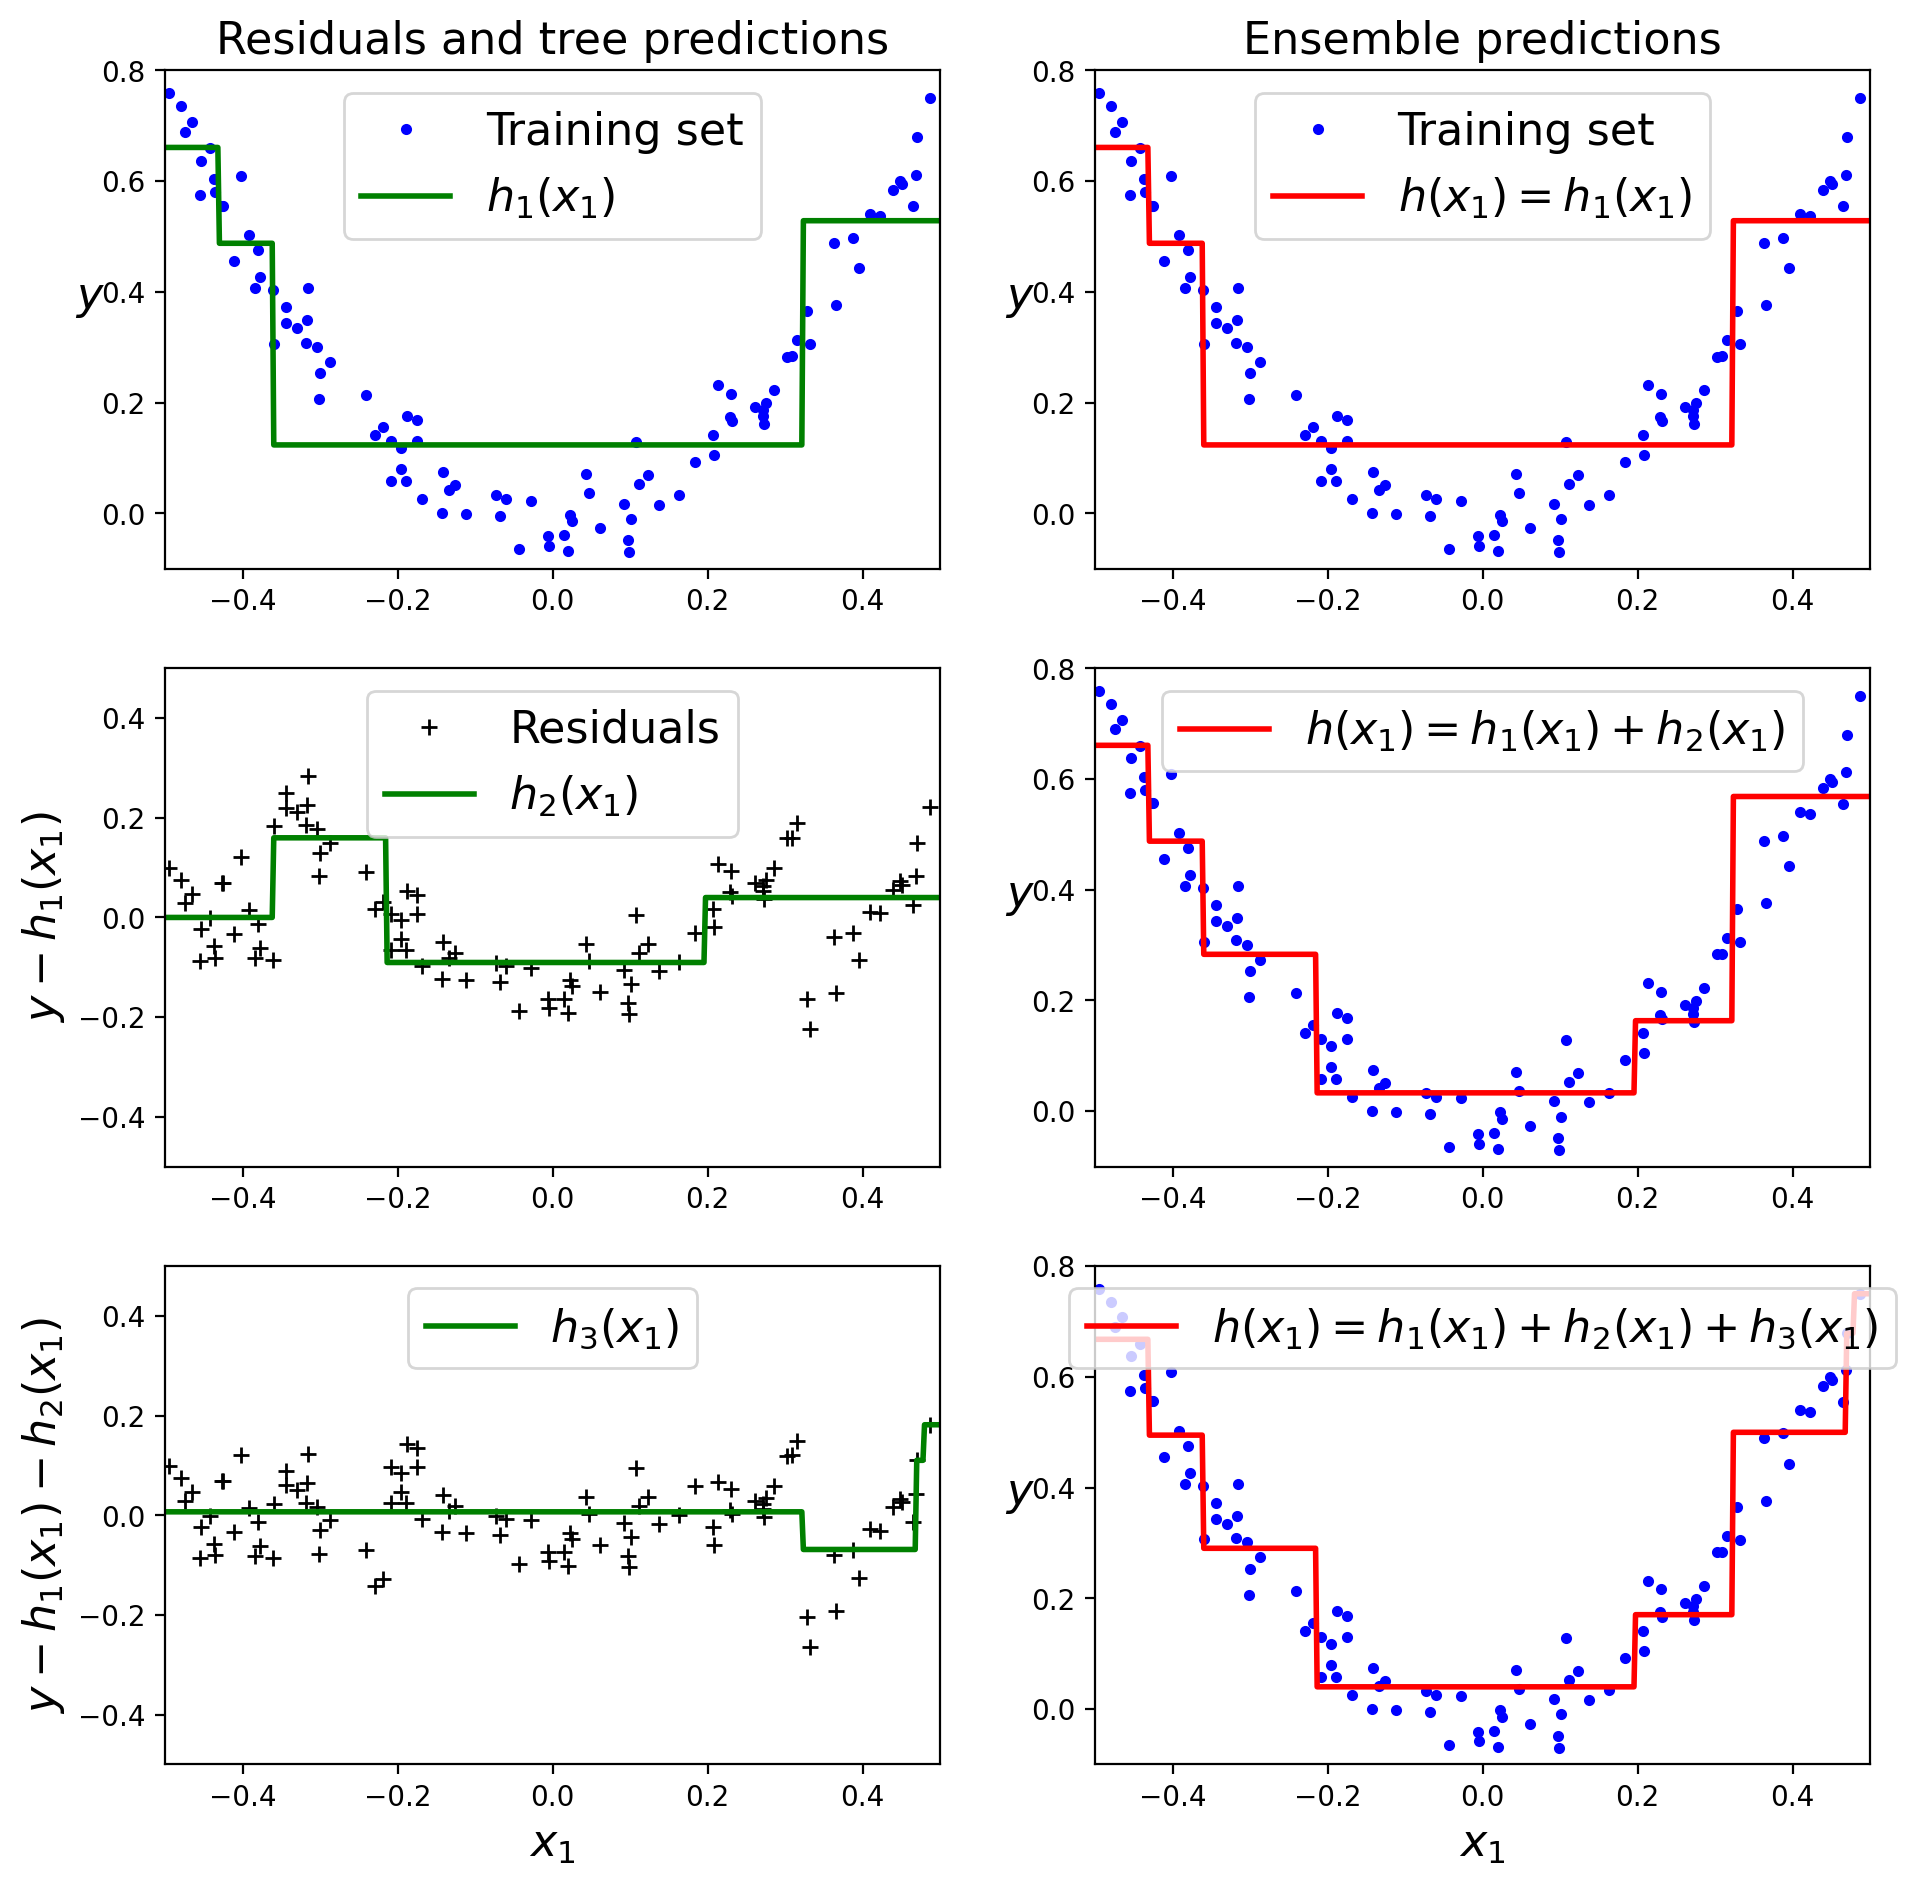

In [26]:
plt.figure(figsize=(11,11))

# 1단계 ===================================================================================================================
plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)
#왼쪽/오른쪽 regressors가 같으니 그래프 모양은 같다.
plt.subplot(322) 
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

# 2단계 ===================================================================================================================

# reg2를 plotting. reg2는 reg1의 예측 오차를 추정. Y축은 reg1의 예측오차.  
plt.subplot(323)
e = y - tree_reg1.predict(X)
plot_predictions([tree_reg2], X, e, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)
# reg1과 reg2의 예측값을 더하는 앙상블
plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

# 3단계 ===================================================================================================================

# reg3를 plotting. reg3는 reg2의 예측 오차를 추정. Y축은 reg2의 예측오차.
plt.subplot(325)
e2 = e - tree_reg2.predict(X)
plot_predictions([tree_reg3], X, e2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)
# reg1과 reg2, reg3의 예측값을 더하는 앙상블
plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.show()

- 좌측은 예측기의 순차적인 동작을 설명
- 우측은 앙상블의 예측 (합)을 보여준다

### XGBoost
- 성능이 향상된 모델, extreme gb

### LightGBM 
- XGBoost를 개선한 모델

# 보팅
- Stacking
- 투표기반 분류기
- 여러가지 모델을 사용하여 예측을 하고 각 결과를 취합하는 방법
- 직접 투표 또는 간접투표를 선택할 수 있다

## 데이터
- Two Moon Data

In [27]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
X, y = make_moons(n_samples=500, noise=0.35, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

(375, 2)


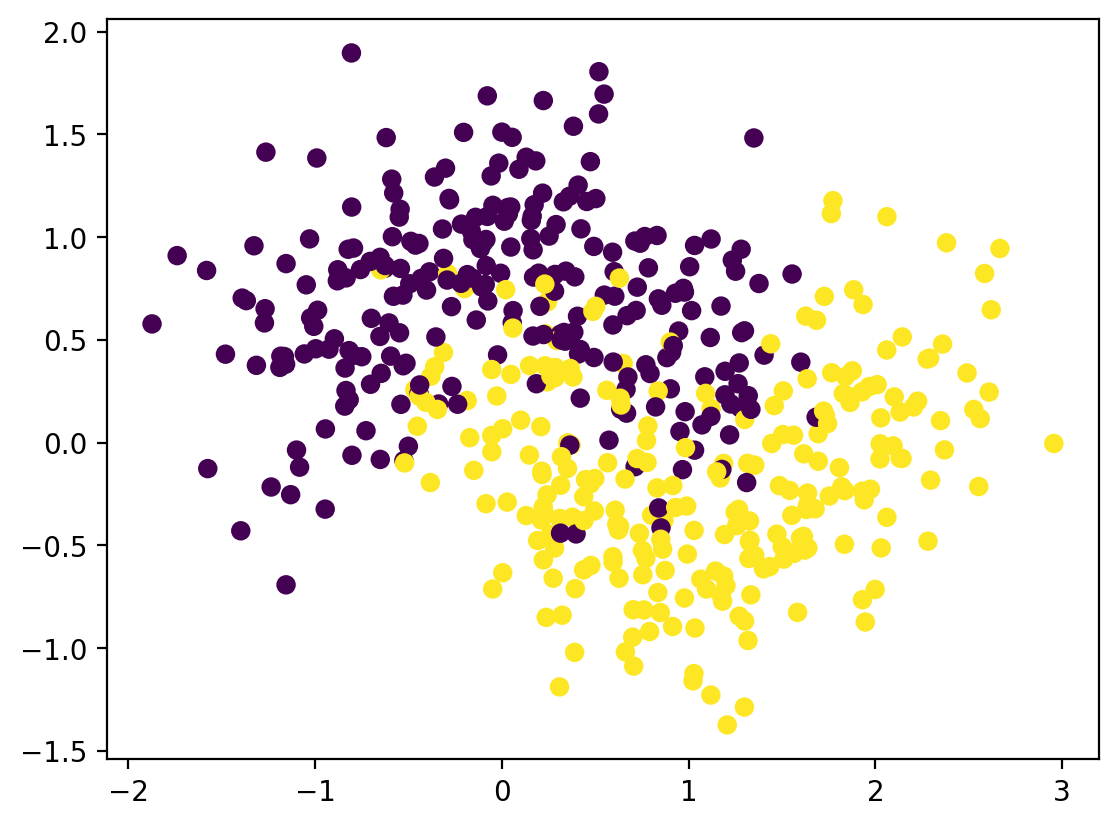

In [28]:
print(X_train.shape)
plt.scatter(X[:,0], X[:,1], c=y)

## 선형분류, 로지스틱회귀, 결정트리, kNN

In [29]:
from sklearn import datasets
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## 손글씨 데이터 로드

In [30]:
mnist = datasets.load_digits()
features, labels = mnist.data, mnist.target
X_train,X_test,y_train,y_test=train_test_split(features,labels,test_size=0.2)

## 단일 모델 정확도 측정
의사결정트리, knn, svm 모델의 정확도를 측정합니다.

In [31]:
dtree = tree.DecisionTreeClassifier(
    criterion="gini", max_depth=8, max_features=32,random_state=35)

dtree = dtree.fit(X_train, y_train)
dtree_predicted = dtree.predict(X_test)

knn = KNeighborsClassifier(n_neighbors=299).fit(X_train, y_train)
knn_predicted = knn.predict(X_test)

# SVC는 클래스 확률을 제공하지 않으므로 이를 얻으려면 명시적으로 probability=True를 지정해야 한다 
# (단, 클래스 확률을 구하기 위해서 교차검증을 해야 하고 속도는 느려진다)
svm = SVC(C=0.1, gamma=0.003,
          probability=True,random_state=35).fit(X_train, y_train)
svm_predicted = svm.predict(X_test)

In [32]:
print("[accuarcy]")
print("d-tree: ",accuracy_score(y_test, dtree_predicted))
print("knn   : ",accuracy_score(y_test, knn_predicted))
print("svm   : ",accuracy_score(y_test, svm_predicted))

[accuarcy]
d-tree:  0.8722222222222222
knn   :  0.8111111111111111
svm   :  0.9194444444444444


소프트 보팅 또는 하드 보팅은 sklearn의 voting classifier를 사용하여 쉽게 구현할 수 있습니다.  
직접 소프트 보팅을 구현하실 때는 predict_proba 함수를 사용하여 테스트 수행 시 측정된 분류값 별 확률을 사용하시면 됩니다.  
아래 SVM으로부터 나온 테스트 데이터 2개의 0부터 9까지의 확률을 보실 수 있습니다.

In [33]:
svm_proba = svm.predict_proba(X_test)
print(svm_proba[0:2])

[[1.14447854e-04 3.77520168e-05 2.97115941e-05 3.48132404e-05
  9.37988649e-05 5.84710560e-04 6.37112134e-05 9.98364249e-01
  5.19277237e-04 1.57527962e-04]
 [4.57256695e-03 1.36652191e-02 1.05434351e-02 4.88413645e-02
  1.24964199e-02 4.17029774e-02 4.68323574e-03 1.00310012e-02
  8.04991395e-02 7.72964641e-01]]


## 하드 보팅
하드 보팅은 일반적인 투표와 같이, 각각의 분류기의 예측값들을 모아, 가장 많은 득표를 받은 예측값으로 최종 결론을 내는 방식입니다.

In [34]:
voting_clf = VotingClassifier(estimators=[
    ('decision_tree', dtree), ('knn', knn), ('svm', svm)], 
    weights=[1,1,1], voting='hard').fit(X_train, y_train)
hard_voting_predicted = voting_clf.predict(X_test)
accuracy_score(y_test, hard_voting_predicted)

0.9222222222222223

## 소프트 보팅
소프트 보팅은 각각의 분류모델의 predict_proba을 활용하여, 모든 분류값들의 확률들을 더해서,  
가장 높은 점수를 획득한 분류값으로 최종 결론을 내는 방식입니다.

In [35]:
voting_clf = VotingClassifier(estimators=[
    ('decision_tree', dtree), ('knn', knn), ('svm', svm)], 
    weights=[1,1,1], voting='soft').fit(X_train, y_train)
soft_voting_predicted = voting_clf.predict(X_test)
accuracy_score(y_test, soft_voting_predicted)

0.9277777777777778

## 정확도 비교 시각화

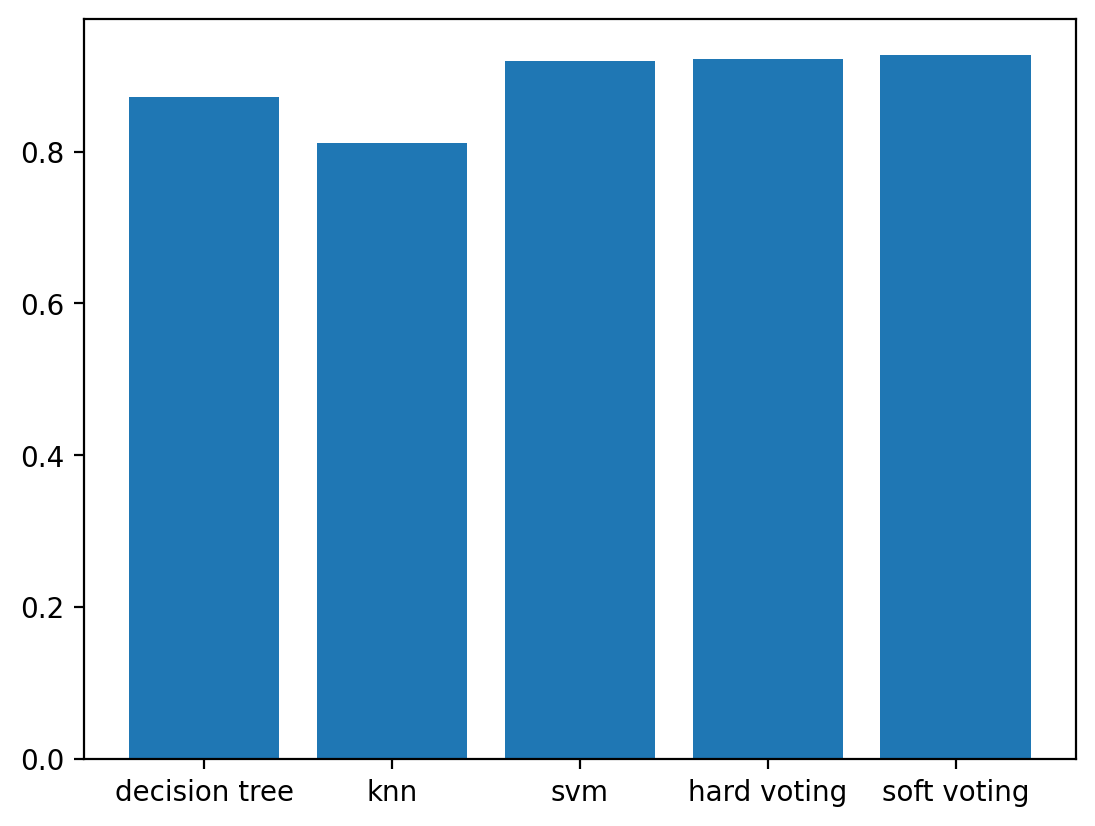

In [36]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

x = np.arange(5)
plt.bar(x, height= [accuracy_score(y_test, dtree_predicted),
                    accuracy_score(y_test, knn_predicted),
                    accuracy_score(y_test, svm_predicted),
                    accuracy_score(y_test, hard_voting_predicted),
                    accuracy_score(y_test, soft_voting_predicted)])
plt.xticks(x, ['decision tree','knn','svm','hard voting','soft voting']);